### **🐻비전 트랜스포머 기반 쿼리 이미지의 유사 이미지 검출 코드 (로컬 AI모델 사용)**

이미지 인코더인 비전 트랜스포머(ViT, Vision Transformer)를 사용하여 dense representation (embedding)을 추출하여 쿼리 이미지(query image)와 후보 이미지들(candidate images)의 유사도를 모두 계산하여 **유사한 이미지들**을 검출하는 코드입니다.

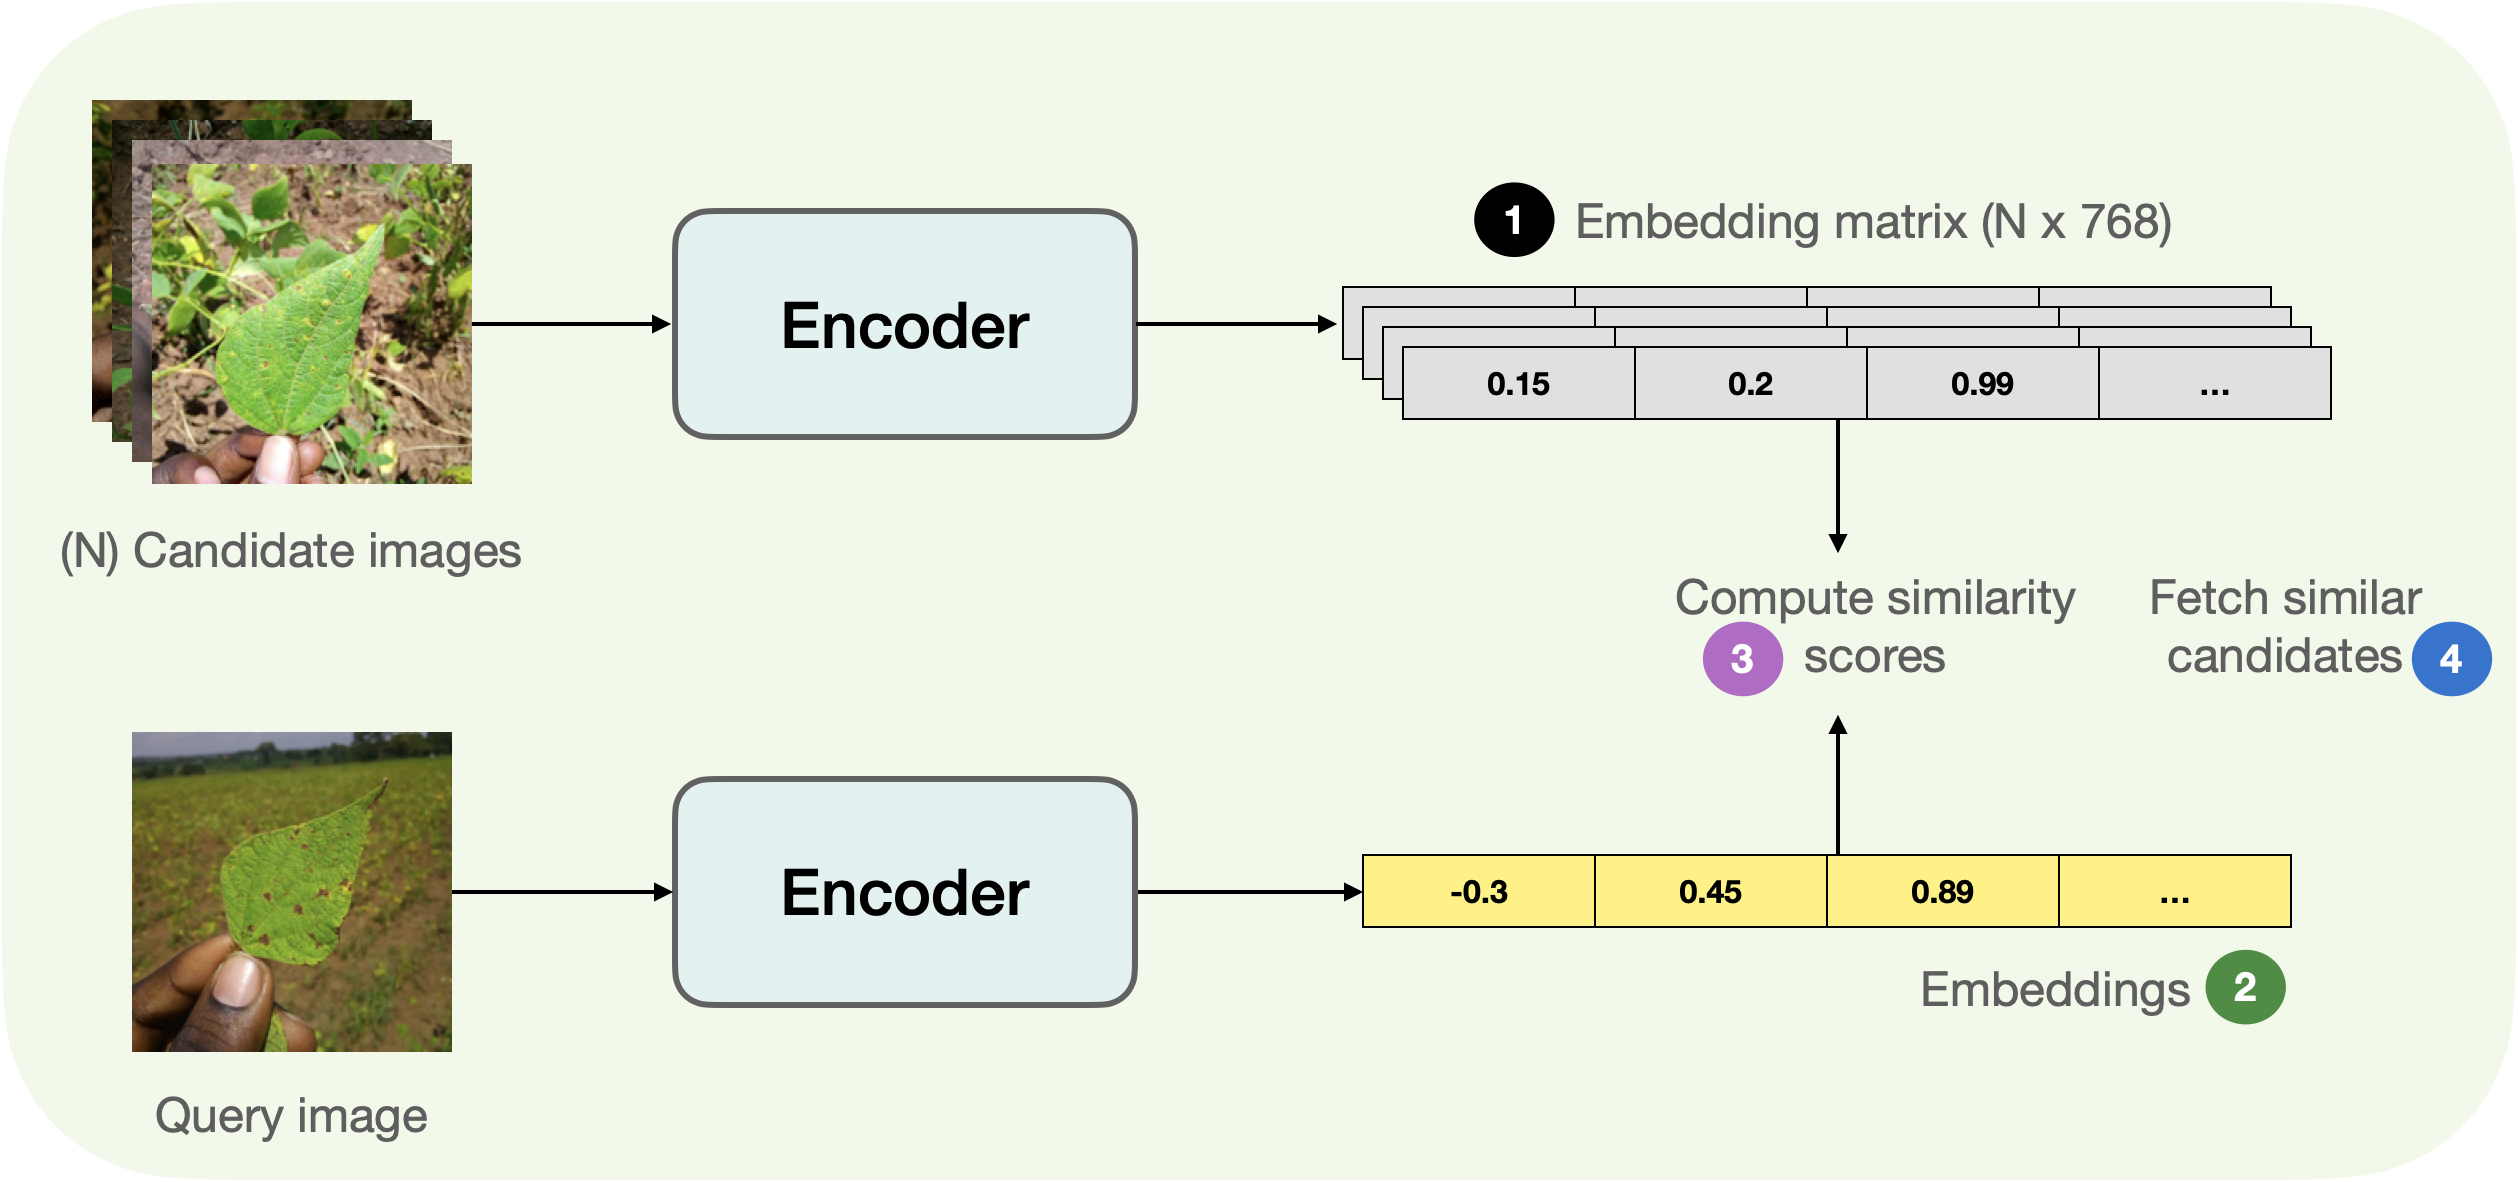

### **🐻이 코드는 다음과 같이 작동합니다:**

지정된 폴더에서 모든 이미지를 로드합니다.
모든 이미지에 대해 임베딩을 계산합니다.
첫 번째 이미지를 query 이미지로 사용합니다.
query 이미지와 가장 유사한 5개의 이미지를 찾습니다.
query 이미지와 유사한 이미지들을 시각화하여 보여줍니다.

### **🐻사용하기 전에 다음 사항을 확인해주세요:**

folder_path 변수를 실제 이미지가 있는 폴더 경로로 설정해주세요.
필요한 라이브러리들(transformers, torch, PIL, matplotlib 등)이 설치되어 있어야 합니다.

이 코드를 실행하면 query 이미지와 가장 유사한 5개의 이미지를 시각적으로 확인할 수 있습니다.

Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


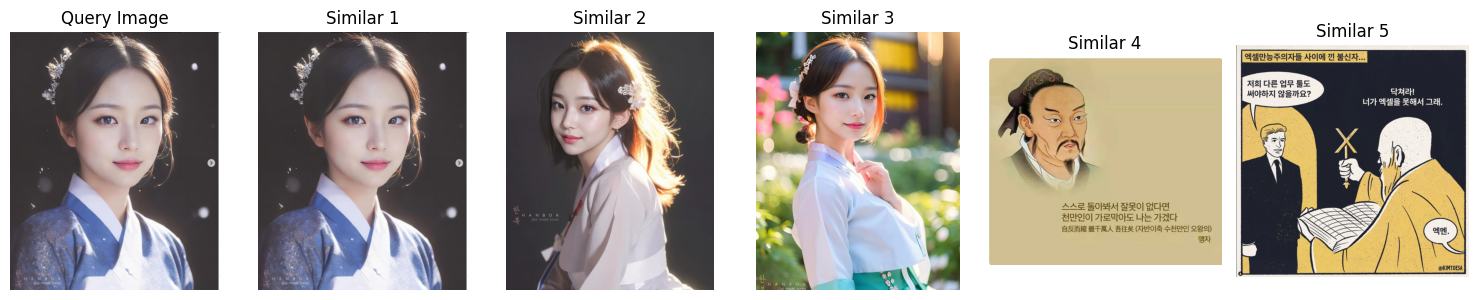

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, AutoModel
import torch
import torchvision.transforms as T
import numpy as np
from tqdm import tqdm

# 모델 및 특징 추출기 로드
model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size



# Query 이미지 선택 (첫 번째 이미지를 query로 사용)
query_image = images[0]

# 데이터 변환 체인
transformation_chain = T.Compose([
    T.Resize(int((256 / 224) * extractor.size["height"])),
    T.CenterCrop(extractor.size["height"]),
    T.ToTensor(),
    T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
])

def extract_embeddings(model: torch.nn.Module):
    device = model.device

    def pp(images):
        image_batch_transformed = torch.stack([transformation_chain(image) for image in images])
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return embeddings

    return pp

def compute_scores(emb_one, emb_two):
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()

def fetch_similar(query_embeddings, all_samples_embeddings, candidate_images, top_k=5):
    sim_scores = compute_scores(all_samples_embeddings, query_embeddings)
    similarity_mapping = dict(zip(range(len(candidate_images)), sim_scores))
    similarity_mapping_sorted = dict(sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True))
    top_indices = list(similarity_mapping_sorted.keys())[:top_k]
    return [candidate_images[i] for i in top_indices]

# 이미지 로드 함수
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder_path, filename)
            images.append(Image.open(img_path).convert("RGB"))
    return images

# 메인 코드
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    extract_fn = extract_embeddings(model)

    # 이미지 폴더 경로 설정 (예: "./images")
    folder_path = "./images"

    # 이미지 로드
    images = load_images_from_folder(folder_path)

    if not images:
        print("No images found in the specified folder.")
        exit()

    # 임베딩 계산
    all_samples_embeddings = extract_fn(images)

    query_embeddings = extract_fn([query_image])

    # 유사한 이미지 찾기
    similar_images = fetch_similar(query_embeddings, all_samples_embeddings, images)

    # 결과 출력
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis('off')

    for i, img in enumerate(similar_images, start=2):
        plt.subplot(1, 6, i)
        plt.imshow(img)
        plt.title(f"Similar {i-1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()